# Вывод термодинамических функций при помощи pycalhad

1. Загрузить базу данных для чистых элементов ‘Unary.tdb’ при помощи Database 
2. Выбрать чистый элемент из предложенных 
3. Рассчитать зависимость фазового состава от температуры при помощи функции equilibrium, построить эту зависимость.
- Найти на этом графике Reference state, т.е. какая фаза для данного элемента является стабильной при комнатной температуре (298,15 К)
- Найти температуру плавления . Рассчитать энтальпию плавления при помощи функции equilibrium
4. Получить график зависимости энергий Гиббса равновесных фаз от температуры (относительно Reference state- фазы, стабильной при 298,15 К).
- Найти на этом графике температуры фазовых превращений, отметить для себя-какие фазы стабильны при разных температурах
5. Построить на одном графике зависимости теплоемкостей от температуры для всех равновесных фаз. 
- Предложить, с чем могут быть связаны изломы (если они есть) на кривых зависимости  теплоемкости от температуры 
6. Построить зависимость энтальпий фаз от температуры. 
- Найти на этом графике энтальпии всех фаз при комнатной температуре и энтальпию плавления


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pycalphad import Database, equilibrium, calculate
from pycalphad import variables as v
from pycalphad.plot.utils import phase_legend

### 1. Подгрузим базу данных и зададим константы

In [2]:
db = Database('Unary.tdb')

min_temp = 299 # комнатная
max_temp = 3000
press = 101325 # атмосферное давление, константа

2. Для расчетов я выбрала цирконий.
Определим фазы, характерные для данного вещества.

In [3]:
# элементы и фазы для расчета
elements = ['Zr', 'VA']
phases = list(db.phases.keys())

# условия расчета
temp = range(min_temp, max_temp, 10) # нижняя граница - комнатная температура
el_cnt = 1 # кол-во вещества на 1 моль
conditions = {v.P: press, v.T: temp, v.N: el_cnt}

eq = equilibrium(db, elements, phases, conditions)
np.unique(eq.Phase)

array(['', 'BCC_A2', 'HCP_A3', 'LIQUID'], dtype='<U16')

### 3. Рассчитаем зависимость фазового состава от температуры | Диаграмма состояний

1. Найти на графике стабильную фазу при комнатной температуре (298,15 К)
2. Найти температуру плавления
3. Рассчитать энтальпию плавления

Температура плавления: 2129.0 K
Стабильная фаза при комнатной температуре: HCP_A3


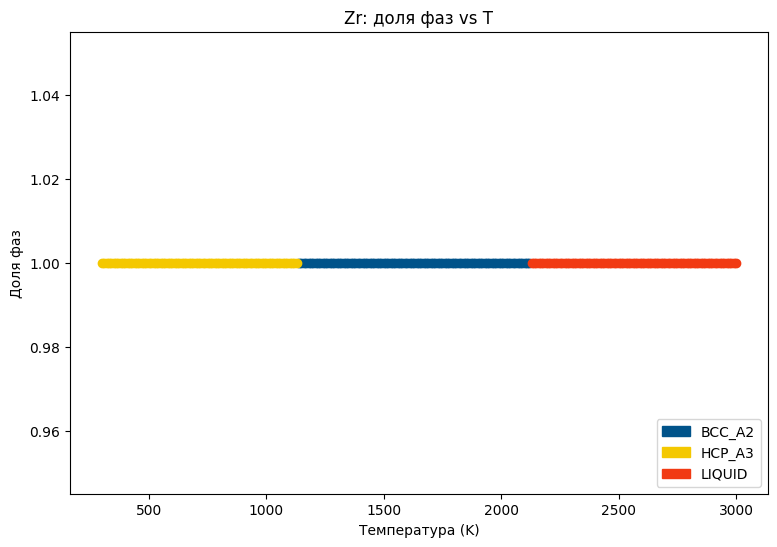

In [4]:
phases = ['BCC_A2', 'HCP_A3', 'LIQUID']

phase_handles, phasemap = phase_legend(phases)
fig = plt.figure(figsize=(9,6))
plt.gca().set_title('Zr: доля фаз vs T')
plt.gca().set_xlabel('Температура (K)')
plt.gca().set_ylabel('Доля фаз')
# plt.gca().set_xlim((min(temp), max(temp)))

ref_state = ''
liquid_temp = 0
for name in phases:
    phase_indices = np.nonzero(eq.Phase.values == name)
    temp_phase = np.take(eq['T'].values, phase_indices[2])
    plt.scatter(temp_phase, eq.NP.values[phase_indices], color=phasemap[name])
    if  min_temp in temp_phase: # если температура комнатная (нижняя граница), то выдай фазу
        ref_state = name
    if name == 'LIQUID': # для жидкой фазы, выдай минимальную температуру
        liquid_temp = min(temp_phase)

print(f"Температура плавления: {liquid_temp} K")    
print(f"Стабильная фаза при комнатной температуре: {ref_state}")    
plt.gca().legend(phase_handles, phases, loc='lower right')

### 4. График зависимости энергий Гиббса равновесных фаз от температуры 

1. Найти на этом графике температуры фазовых превращений
2. Отметить для себя-какие фазы стабильны при разных температурах

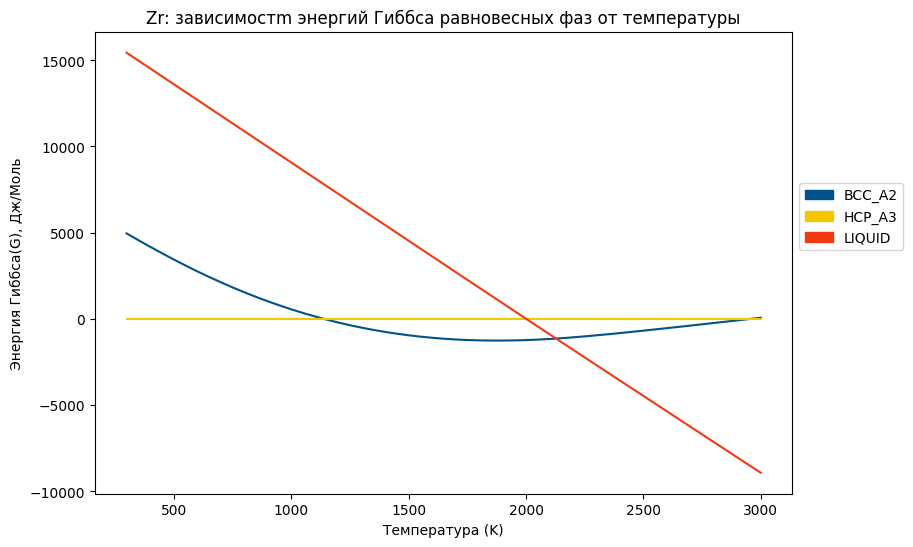

In [5]:
fig = plt.figure(figsize=(9,6))
plt.gca().set_ylabel('Энергия Гиббса(G), Дж/Моль')
plt.gca().set_xlabel('Температура (K)')
ax = fig.gca()
reference_state =  calculate(db, elements, ref_state, P=press, T=temp, output='GM')
for name in phases:
    result = calculate(db, elements, name, P=press, T=temp, output='GM')
    plt.plot(temp, result.GM[0][0] - reference_state.GM[0][0], color=phasemap[name.upper()])
ax.legend(handles=phase_handles, loc='center left', bbox_to_anchor=(1, 0.6))
    

plt.gca().set_title('Zr: зависимостm энергий Гиббса равновесных фаз от температуры')
plt.show()

### 5. График зависимостей теплоемкостей от температуры для всех равновесных фаз.

Предложить, с чем могут быть связаны изломы (если они есть) на кривых зависимости теплоемкости от температуры

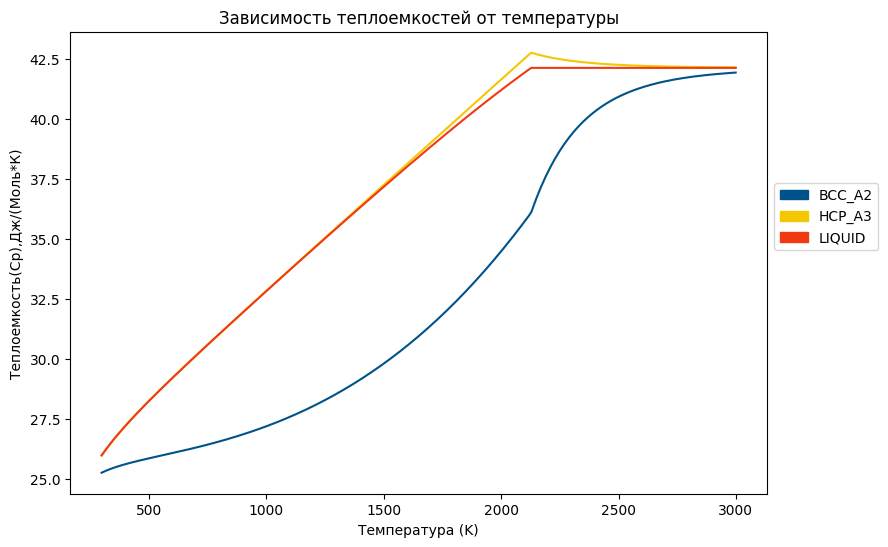

In [6]:
fig = plt.figure(figsize=(9,6))
plt.gca().set_title('Зависимость теплоемкостей от температуры')
plt.gca().set_xlabel('Температура (K)')
plt.gca().set_ylabel('Теплоемкость(Cp),Дж/(Моль*К)')
for phase in phases:
    points = calculate(db, elements, phase, T=temp, P=press, output='heat_capacity')
    plt.plot(points['T'], np.squeeze(points['heat_capacity']), color=phasemap[phase.upper()])
plt.gca().legend(handles=phase_handles, loc='center left', bbox_to_anchor=(1, 0.6))

plt.show()

### 6. График зависимости энтальпий фаз от температуры.

1. Найти на этом графике энтальпии всех фаз при комнатной температуре 
2. и энтальпию плавления

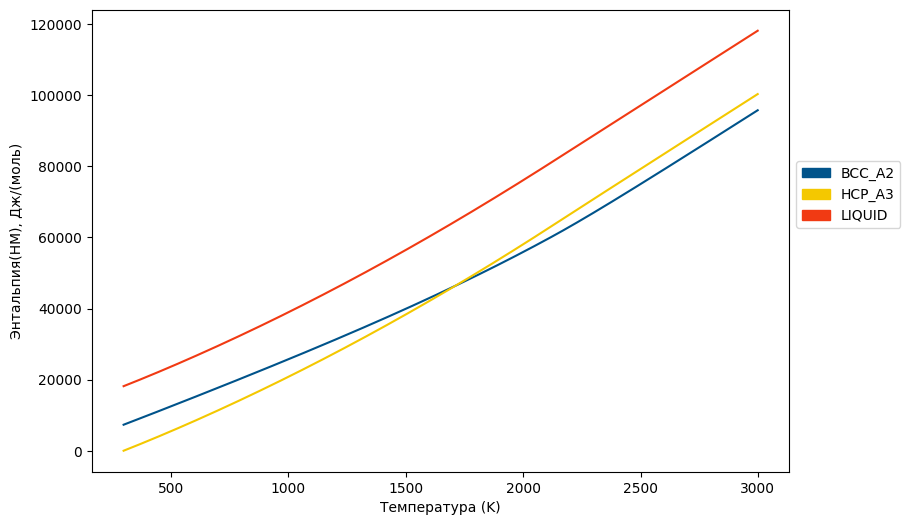

In [7]:
fig = plt.figure(figsize=(9,6))
plt.gca().set_ylabel('Энтальпия(HM), Дж/(моль)')
plt.gca().set_xlabel('Температура (K)')
for name in phases:
    points = calculate(db, elements, name, P=press, T=temp, output='HM')
    plt.plot(temp, points.HM[0][0], color=phasemap[name.upper()])
fig.gca().legend(handles=phase_handles, loc='center left', bbox_to_anchor=(1, 0.6))

#### Рассчитаем энтальпию плавления

In [9]:
liq_state =  calculate(db, elements, 'LIQUID', P=press, T=temp, output='HM') # энтальпия жидкости
ref_state = calculate(db, elements, 'HCP_A3', P=press, T=temp, output='HM') # энтальпия свободной фазы

In [10]:
print(liq_state.HM[0][0][0].item(), ref_state.HM[0][0][0].item()) # последний 0 - индекс комнатной температуры

18169.782255724447 22.09246435146997


In [11]:
(liq_state.HM[0][0][0] - ref_state.HM[0][0][0]).item() # энтальпия плавления

18147.689791372977

(0.0, 20000.0)

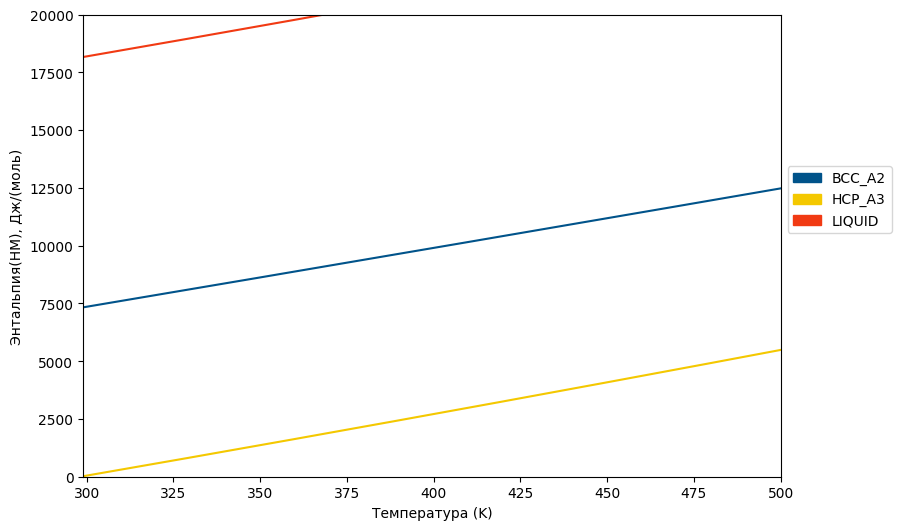

In [12]:
fig = plt.figure(figsize=(9,6))
plt.gca().set_ylabel('Энтальпия(HM), Дж/(моль)')
plt.gca().set_xlabel('Температура (K)')
for name in phases:
    points = calculate(db, elements, name, P=press, T=temp, output='HM')
    plt.plot(temp, points.HM[0][0], color=phasemap[name.upper()])
fig.gca().legend(handles=phase_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.gca().set_xlim((min_temp, 500))
plt.gca().set_ylim((0 , 20000))